In [5]:
import torch
import clip
from PIL import Image
import numpy as np
import glob
import math
from scipy import spatial
import os

In [6]:
device = "cuda"
print(device)
model, preprocess = clip.load("ViT-B/16", device=device)

cuda


In [5]:
des_path =  "data/CLIP_Features/"
paths = "data/KeyFramesC00_V00/"

video_paths = sorted(glob.glob(f"{paths}/*/"))
video_paths = ['/'.join(i.split('/')[:-1]) for i in video_paths]

# os.makedirs(des_path, exist_ok=True)

import time
start_time = time.time()

flag = 0
for vd_path in video_paths:
  print(vd_path)
  # check_file = int(vd_path.split('/')[-1].replace('C02_V',''))
  # if check_file <= 349:
  #   print(f"Skip: {vd_path}")
  #   continue

  re_feats = []
  keyframe_paths = glob.glob(f'{vd_path}/*.jpg')
  keyframe_paths = sorted(keyframe_paths, key=lambda x : x.split('/')[-1].replace('.jpg',''))

  for keyframe_path in keyframe_paths:
    image = preprocess(Image.open(keyframe_path)).unsqueeze(0).to(device)

    with torch.no_grad():
        image_feats = model.encode_image(image)

    image_feats /= image_feats.norm(dim=-1, keepdim=True)
    image_feats = image_feats.detach().cpu().numpy().astype(np.float16).flatten() 
    
    if flag == 0:
      #  print("Image feat: ", image_feats)
       flag = 1

    re_feats.append(image_feats)

  name_npy = vd_path.split('/')[-1]
  outfile = f'{des_path}/{name_npy}.npy'
  np.save(outfile, re_feats)

print ("Time to extract image features and export npy . file by CLIP: ", time.time() - start_time) 

data/KeyFramesC00_V00/C00_V0000
data/KeyFramesC00_V00/C00_V0001
Time to extract image features and export npy . file by CLIP:  346.0665590763092


# Convert for NGT

In [11]:
des_path =  "data/CLIP_Features/"
paths = "data/KeyFramesC00_V00/"

video_paths = sorted(glob.glob(f"{paths}/*/"))
video_paths = ['/'.join(i.split('/')[:-1]) for i in video_paths]

# os.makedirs(des_path, exist_ok=True)
re_shape = [] #
for vd_path in video_paths:
  print(vd_path)

  re_dirs = [] #
  re_feats = [] #

  keyframe_paths = glob.glob(f'{vd_path}/*.jpg')
  keyframe_paths = sorted(keyframe_paths, key=lambda x : x.split('/')[-1].replace('.jpg',''))

  for keyframe_path in keyframe_paths:
    image = preprocess(Image.open(keyframe_path)).unsqueeze(0).to(device)

    with torch.no_grad():
        image_feats = model.encode_image(image)

    image_feats /= image_feats.norm(dim=-1, keepdim=True)
    image_feats = image_feats.detach().cpu().numpy().astype(np.float16).flatten() 

    re_dirs.append(np.array(keyframe_path))
    re_feats.append(image_feats)
  re_shape.append(np.array([len(keyframe_paths), image_feats.shape[0]]))

  name_npy = vd_path.split('/')[-1]
  outfile = f'{des_path}/{name_npy}.tsv'
  # np.save(outfile, re_feats)
  np.savetxt(outfile, re_feats, delimiter = "\t")

  outfile_dirs = f'{des_path}/{name_npy}_dirs.tsv'
  np.savetxt(outfile_dirs, re_dirs, delimiter = "\t", fmt = "%s")

shape_np = f'{des_path}/shape_arr.tsv'
np.savetxt(shape_np, re_shape, delimiter = "\t",fmt ="%i")
  

data/KeyFramesC00_V00/C00_V0000


KeyboardInterrupt: 

In [ ]:
import numpy as np
import faiss
import glob
import json
import matplotlib.pyplot as plt
import os
import math
import torch
import pandas as pd
import re
import clip

from langdetect import detect

import googletrans
import translate

class Translation:
    def __init__(self, from_lang='vi', to_lang='en', mode='google'):
        # The class Translation is a wrapper for the two translation libraries, googletrans and translate. 
        self.__mode = mode
        self.__from_lang = from_lang
        self.__to_lang = to_lang

        if mode in 'googletrans':
            self.translator = googletrans.Translator()
        elif mode in 'translate':
            self.translator = translate.Translator(from_lang=from_lang,to_lang=to_lang)

    def preprocessing(self, text):
        """
        It takes a string as input, and returns a string with all the letters in lowercase
        :param text: The text to be processed
        :return: The text is being returned in lowercase.
        """
        return text.lower()

    def __call__(self, text):
        """
        The function takes in a text and preprocesses it before translation
        :param text: The text to be translated
        :return: The translated text.
        """
        text = self.preprocessing(text)
        return self.translator.translate(text) if self.__mode in 'translate' \
                else self.translator.translate(text, dest=self.__to_lang).text
    
def show_images(image_paths):
    fig = plt.figure(figsize=(15, 10))
    columns = int(math.sqrt(len(image_paths)))
    rows = int(np.ceil(len(image_paths)/columns))

    for i in range(1, columns*rows +1):
        img = plt.imread(image_paths[i - 1])
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

        plt.imshow(img)
        plt.axis("off")
        
    plt.show()

def text_search(text):
    model, preprocess = clip.load("ViT-B/16", device="cuda")
    trans = Translation()
    text = trans(text)

    ###### TEXT FEATURES EXACTING ######
    text = clip.tokenize([text]).to("cuda")  
    text_features = model.encode_text(text).cpu().detach().numpy().astype(np.float32)
    return text_features

In [ ]:
text = "MC đang dẫn chương trình"
text = list(text_search(text)[0])
print(list(text))

[0.1665039, -0.06210327, -0.032196045, -0.32788086, 0.36401367, -0.020614624, 0.16223145, -0.15026855, -0.025360107, -0.0061302185, 0.49560547, -0.29907227, -0.038848877, 0.021133423, 0.01651001, 0.18054199, -0.017028809, -0.095947266, 0.28686523, -0.20483398, -0.36816406, -0.30249023, -0.2783203, 0.3569336, 0.015213013, 0.24084473, -0.22485352, 0.24536133, 0.020950317, 0.28320312, -0.4387207, 0.25170898, -0.08465576, 0.16125488, 0.12573242, 0.32788086, 0.03741455, 0.3642578, 0.17822266, -0.6875, 0.09564209, 0.25439453, 0.19750977, 0.057891846, -0.13696289, -0.4267578, 0.21826172, -0.043670654, -0.22937012, 0.103149414, 0.50634766, 0.012771606, -0.17456055, -0.083862305, 0.36401367, -0.36206055, 0.32958984, 0.02557373, 0.20751953, -0.07086182, -0.25634766, -0.25756836, -0.09118652, -0.05795288, -0.06524658, 0.16052246, 0.24633789, -0.1005249, -0.29248047, 0.18066406, 0.17993164, 0.59472656, -0.18078613, 0.0055999756, 0.11798096, 0.12548828, -0.18041992, 0.061065674, 0.2109375, 0.141723

In [10]:
import ngtpy

print('loading words...')
with open('data/CLIP_Features/C00_V0000_dirs.tsv', 'r') as fin:
    words = list(map(lambda x: x.rstrip('\n'), fin.readlines()))

index = ngtpy.Index('data/CLIP_Features/CLIP_Index', zero_based_numbering = False) # open index
# text = " Hai người đang dẫn chương trình"

img_arr = []
# print('query_object: ', text)
result = index.search(text) # aproximate nearest neighbor search
print('Rank\tID\tDistance\tWord')
for rank, object in enumerate(result):
    print('{}\t{}\t{:.6f}\t{}'.format(rank + 1, object[0], object[1], words[object[0] - 1]))
    img_arr.append(words[object[0] - 1])
    if rank+1 == 9:
        break

loading words...
Rank	ID	Distance	Word


IndexError: list index out of range

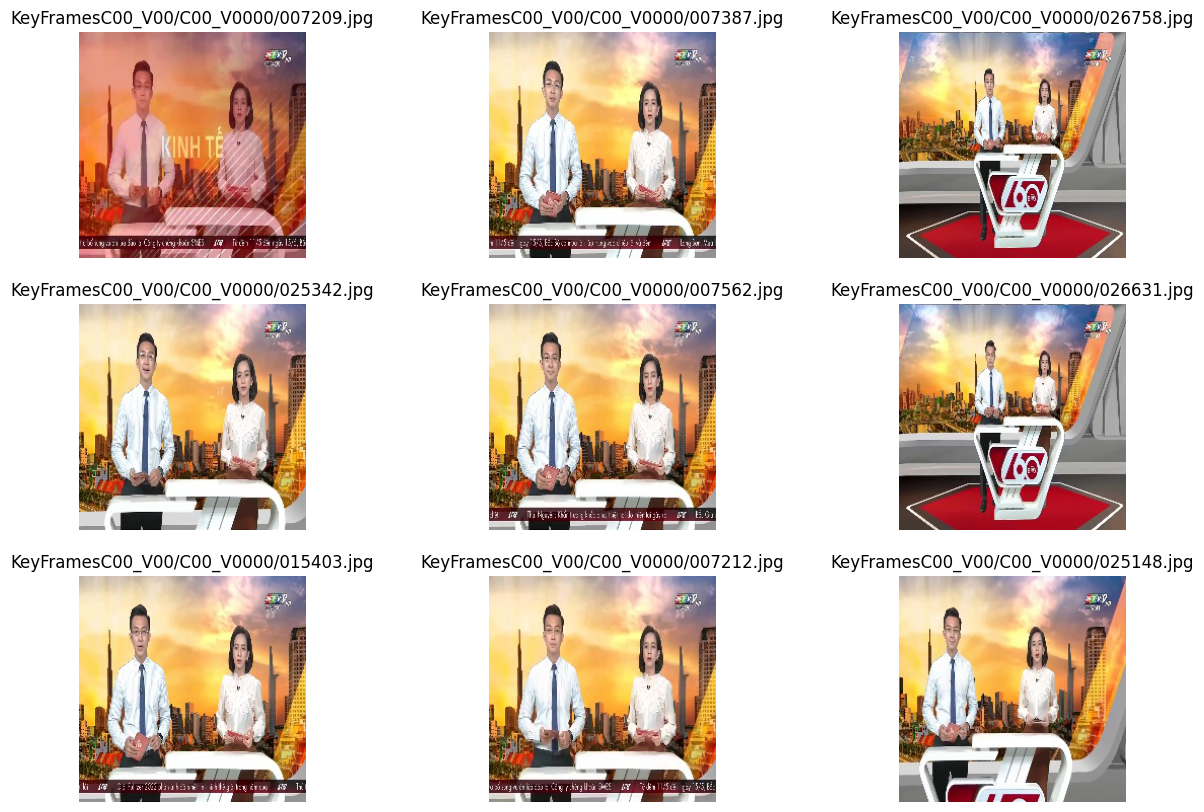

In [15]:
show_images(img_arr)